# Examen Python data developer
# Deel 1
## Introductie
Voor dit examen is het belangrijk dat je volgende zaken zeker doet:
 - Maak een Vitual Environment aan & exporteer een `.yml` (of soortgelijke) file aan die je toevoegt aan je codebase.
 - Maak een github pagina aan met een bijhorende `.gitignore` en `readme.md`. Voeg een link naar de github repo toe aan je readme file.
 - Zorg dat je op het einde de tijd neemt om je code op te schonen zodat deze begrijpelijk is voor derden.
 - Wanneer je klaar bent, maak een `.zip` bestand van je volledige codebase aan en laad deze op in de leeromgeving.

In deze opgave bekijken we een gesimuleerde dataset over de geboortes in België van 2019. De data is te vinden in `.csv` bestanden die gelabeld zijn met de echte geboortedag van de personen in het bestand. Laat ons bijvoorbeeld even kijken naar de eerste 5 lijnen van het bestand `2019-1-1.csv`:

<table align="center">
  <tr>
    <th>gemeente</th>
    <th>naam</th>
    <th>geslacht</th>
    <th>verwachte datum</th>
  </tr>
  <tr>
    <td>Hooglede</td>
    <td>Elias</td>
    <td>Mannelijk</td>
    <td>01/14/2019</td>
  </tr>
  <tr>
    <td>Sint-Niklaas (Sint-Niklaas)</td>
    <td>Pauline</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Wijnegem</td>
    <td>Anita</td>
    <td>Vrouwelijk</td>
    <td>01/05/2019</td>
  </tr>
  <tr>
    <td>Grâce-Hollogne</td>
    <td>Jean-Paul</td>
    <td>Mannelijk</td>
    <td>01/13/2019</td>
  </tr>
  <tr>
    <td>Boussu</td>
    <td>François</td>
    <td>Mannelijk</td>
    <td>01/26/2019</td>
  </tr>
</table>


Hier hebben we de kolommen:
 - **gemeente**: De gemeente waar de persoon geboren is.
 - **naam**: De voornaam van de persoon.
 - **geslacht**: Het geslacht van de persoon (Mannelijk of Vrouwelijk).
 - **verwachte datum**: De verwachte geboortedatum van de persoon.

Dus hier hebben we dan bijvoorbeeld op de eerste lijn de mannelijke persoon Elias die geboren is in Hooglede waarvan men verwachtte dat hij zou geboren worden op `01/14/2019` (Amerikaans formaat) maar in feite geboren is op 1 januari 2019.

Doorheen deze opgave gaan we de data van dichterbij inspecteren! Je kan deze opgaves alternatief lezen in de bijgeleverde notebook `examen.ipynb` waar ook de (meeste) afbeeldingen & resultaten zichtbaar zijn.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
import matplotlib.pyplot as plt 
from tqdm import tqdm

# Importing & loading my personal favorite standard plot style settings
sys.path.append('../scripts/utilities')
from standard_style import standard_style
standard_style()

# Definieer data locaties
input_path = os.path.join('..', 'data', 'input')
output_path = os.path.join('..', 'data', 'output')

## Utilities

In [2]:
def to_percentage(number):
    return str(np.round(number * 100, 2)) + "%"

def compute_num_unique(df, n_births):
    return len(np.unique(df['naam'].sample(n_births)))

def is_valid_date(date_str):
  """
  Checks if the given date string is a valid date format (YYYY-MM-DD)
  and handles February 29th for leap years.

  Args:
      date_str: The date string to validate.

  Returns:
      A pandas datetime object if the date is valid, None otherwise.
  """
  try:
    date = pd.to_datetime(date_str, format="%Y-%m-%d", errors="coerce")
    if not pd.isnull(date) and date.month == 2 and date.day == 29:
      # Check for leap year
      if date.year % 4 == 0 and (date.year % 100 != 0 or date.year % 400 == 0):
        return date
      else:
        return None  # Not a leap year, so invalid 29th of February
    else:
      return date  # Valid date (not 29th of February)
  except ValueError:
    return None  # Invalid date format


## Stap 1: data inlezen

Maak een lus over alle bestanden in de map `data/geboortes`, lees elk `.csv` bestand in en voeg deze samen tot 1 grote DataFrame. Merk op dat de datum verwerkt zit in de filename, voeg deze toe aan de kleine DataFrames voor je de dataframes samenvoegt met een `pd.concat(dfs)`.

Voeg een extra kolom toe met een `"dag van het jaar"` getal, dus 1 januari 2019 is `1`, 2 januari 2019 is `2`, enzovoort.

**Opmerking**: Er is ook data voor 29 februari 2019, terwijl dit geen schrikkeljaar is! Plaats deze geboortes in een afzonderlijke DataFrame `df_wrong`. Zet in `df_wrong` een extra kolom met een referentie naar waarom deze data foutief is.

### Loading data

In [3]:
# Loading data - of all csv-files in the input folder - in the dataframe

# declaring 2 empty list to store dataframes for each birthdate - one for the right birthdates and one for the wrong birthdates
dfs_right_list = []
dfs_wrong_list = []

# Looping through each file in the input folder, reading the csv files and adding the birthdate to the dataframe
for filename in tqdm(os.listdir(input_path)):
    if filename.endswith(".csv"):
        full_path = os.path.join((input_path), filename)
        with open(full_path, 'r') as f:
            df = pd.read_csv(full_path, sep=',')
            # Adding birthdate to each record - sourced from the filename and removing the .csv extension
            df['geboorte datum'] = filename.split(".csv")[0]
            # Check if the birthdate is valid
            if not pd.isna(is_valid_date(filename.split(".csv")[0])):
                dfs_right_list.append(df)
            else:
                df['why_wrong'] = "Invalid date"
                dfs_wrong_list.append(df)

# Concatenate both lists to one dataframe for each list
geboortes = pd.concat(dfs_right_list, ignore_index=True)
df_wrong = pd.concat(dfs_wrong_list, ignore_index=True)

100%|██████████| 366/366 [00:00<00:00, 1045.77it/s]


### Preprocessing

In [4]:
def clean_df(df):
    # Convert columns containing dates to datetime
    df['geboorte datum'] = pd.to_datetime(df['geboorte datum'])	
    df['verwachte datum'] = pd.to_datetime(df['verwachte datum'])	

    # Convert columns containing categorical data to category
    df['geslacht'] = df['geslacht'].astype('category')

    # Adding new column, 'dag van het jaar'
    df['dag van het jaar'] = df['geboorte datum'].dt.dayofyear
    
    return df

In [5]:
geboortes = clean_df(geboortes)

## Stap 2: Dagelijks aantal geboortes bekijken
#### Vraag 1: Maak een plot van het aantal geboortes per dag van het jaar. 

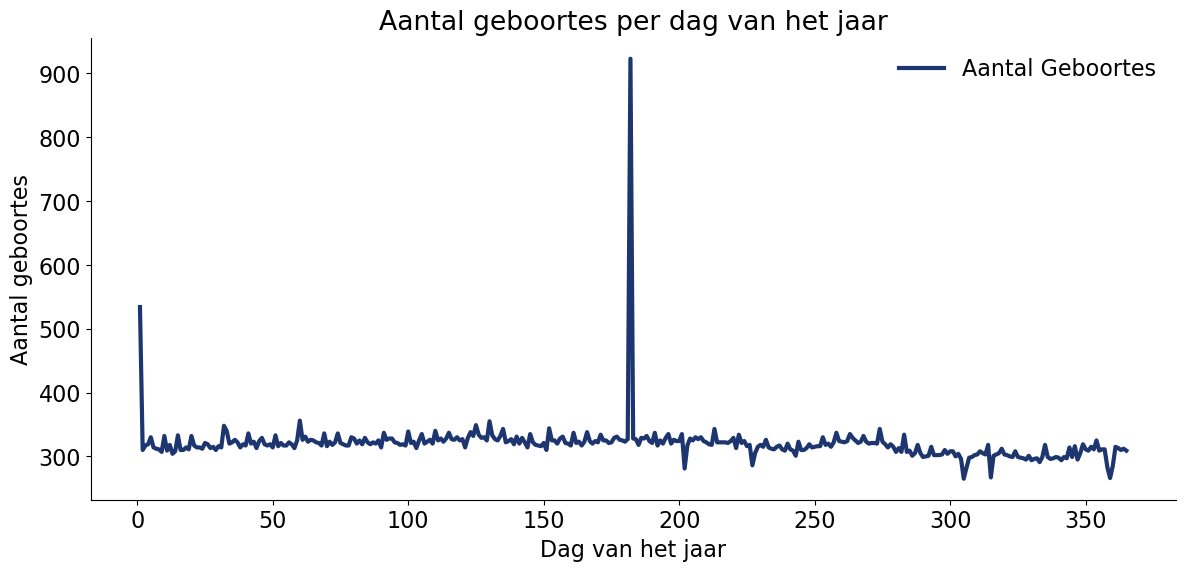

In [6]:
fig, ax = plt.subplots()

(geboortes.groupby('dag van het jaar')
            .size()
            .plot(ax = ax, label = 'Aantal Geboortes'))

ax.set_title('Aantal geboortes per dag van het jaar')
ax.set_ylabel('Aantal geboortes')
ax.set_xlabel('Dag van het jaar')
ax.legend()

#### Vraag 2: Outliers vinden & behandelen

We klassificeren een datum als een outlier als het aantal geboortes meer dan `50%` afwijkt van de gemiddelde waarde overheen de volledige dataset. Zoek alle outliers in de dataset.

In [7]:
# Calculate average birth count
mean_geboortes = geboortes['geboorte datum'].value_counts().mean()

# Calculate 50% threshold
threshold = mean_geboortes * 0.5

# Group by date and calculate birth counts
geboortes_per_dag = geboortes.groupby('geboorte datum')['geboorte datum'].count()

# Identify outliers in groupby object based on threshold
outlier_dates = geboortes_per_dag[(geboortes_per_dag - mean_geboortes).abs() > threshold].index.tolist()

outlier_dates

[Timestamp('2019-01-01 00:00:00'), Timestamp('2019-07-01 00:00:00')]

Ik zal je vertellen; de outliers op 1 januari en 1 juli komen doordat alle geboortes waarvoor de datum niet correct genoteerd is, de datum 1 januari (voor de eerste helft van het jaar) en op 1 juli (voor de tweede helft van het jaar) geplaatst worden. Om dit op te lossen, halen we in de grote geboortes DataFrame (met 1 lijn per geboorte) deze twee datums er volledig uit. Dus we gaan **alle** geboortes van 1 januari en 1 juli verwijderen uit deze dataframe en toevoegen aan de `df_wrong` dataframe met als reden `2019-01-01` en `2019-07-01`.

In [8]:
geboortes[geboortes['geboorte datum'].isin(outlier_dates)]

,gemeente,naam,geslacht,verwachte datum,geboorte datum,dag van het jaar
67043,Hooglede,Elias,Mannelijk,2019-01-14,2019-01-01,1
67044,Sint-Niklaas (Sint-Niklaas),Pauline,Vrouwelijk,2019-01-05,2019-01-01,1
67045,Wijnegem,Anita,Vrouwelijk,2019-01-05,2019-01-01,1
67046,Grâce-Hollogne,Jean-Paul,Mannelijk,2019-01-13,2019-01-01,1
67047,Boussu,François,Mannelijk,2019-01-26,2019-01-01,1
...,...,...,...,...,...,...
84770,Oostende,Magali,Vrouwelijk,2019-07-15,2019-07-01,182
84771,Rotselaar,Jean,Mannelijk,2019-06-30,2019-07-01,182
84772,Brussel,Lina,Vrouwelijk,2019-07-11,2019-07-01,182
84773,Hamont-Achel,Brenda,Vrouwelijk,2019-06-25,2019-07-01,182


In [9]:
# Filter outliers from 'geboortes' in a new dataframe
outliers = geboortes[geboortes['geboorte datum'].isin(outlier_dates)].copy()

# Add reason for removal to outliers
outliers['why_wrong'] = 'Verkeerde datum: ' + outliers['geboorte datum'].dt.strftime('%Y-%m-%d')

# Append outliers dataframe to 'df_wrong'
df_wrong = pd.concat([df_wrong, outliers], ignore_index=True)

# Remove outliers from 'geboortes'
geboortes_clean = geboortes[~geboortes['geboorte datum'].isin(outlier_dates)].reset_index()

In [10]:
outlier_dates

[Timestamp('2019-01-01 00:00:00'), Timestamp('2019-07-01 00:00:00')]

Maak dezelfde plot nu opnieuw met het aantal geboortes per dag.

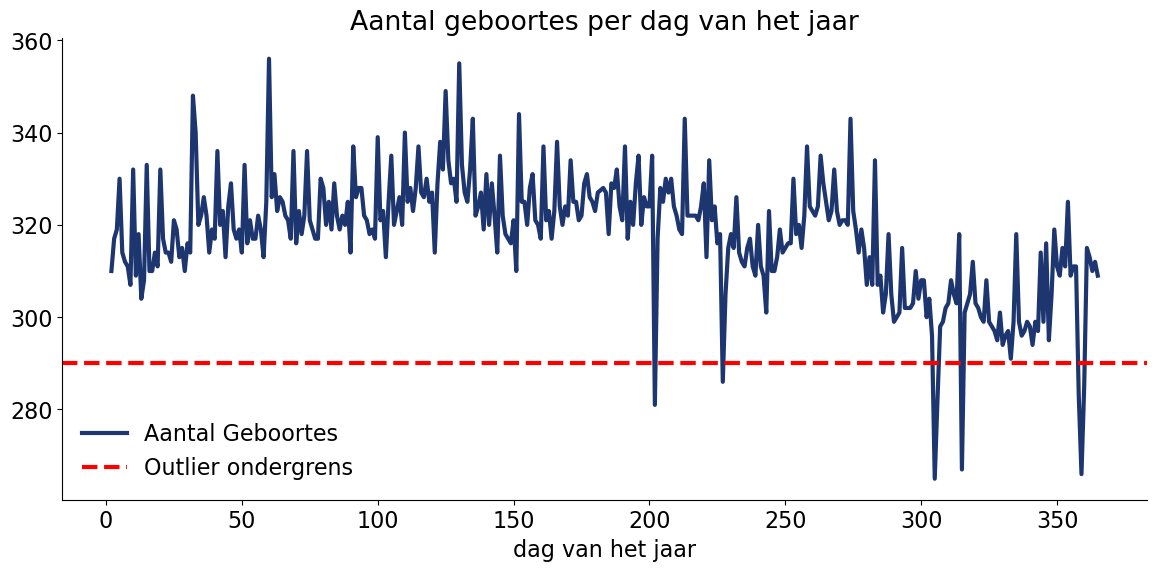

In [11]:
# Calculate limit provided on plot in assignment
lower_limit = (geboortes_clean.groupby('dag van het jaar')
                                        .size()
                                        .mean()
                                        - 2.2*geboortes_clean.groupby('dag van het jaar')
                                        .size()
                                        .std())

# Plot the number of births per day and the lower limit
fig, ax = plt.subplots()

(geboortes_clean.groupby('dag van het jaar')
    .size()
    .plot(ax = ax, label = 'Aantal Geboortes'))

ax.set_title('Aantal geboortes per dag van het jaar')
ax.axhline(lower_limit, color='r', linestyle='--', label='Outlier ondergrens')
ax.legend()

 We zien dat er nog steeds redelijk wat uitschieters zijn, kan je code schrijven om de 5 extreme uitschieters in de 2e helft van het jaar identificeren (in totaal 8 datums)?

In [12]:
# Creating a dataframe with the number of births per day and the requested columns
extreme_outliers = (geboortes_clean[['geboorte datum', 'dag van het jaar']].value_counts()
                                                    .reset_index()
                                                    .rename(columns={'count':'Aantal geboortes'})
                                                    .sort_values(by='Aantal geboortes', ascending=True)
                                                    .reset_index(drop=True))

# Filtering the dataframe to only include days with less than 290 births
extreme_outliers = extreme_outliers[extreme_outliers['Aantal geboortes'] < lower_limit]

extreme_outliers

,geboorte datum,dag van het jaar,Aantal geboortes
0,2019-11-01,305,265
1,2019-12-25,359,266
2,2019-11-11,315,267
3,2019-07-21,202,281
4,2019-11-02,306,282
5,2019-12-24,358,283
6,2019-12-26,360,285
7,2019-08-15,227,286


### Bonusvraag: wekelijkse verbanden

We zien vele pieken en dalen in de evolutie van het aantal geboortes. We willen deze grafiek graag iets "gladder" maken. Kan je hiervoor eens een visualizatie maken van het **gemiddeld** aantal geboortes per week (dit voor elke week, dus maandag-maandag, dinsdag-dinsdag, woensdag-woensdag, ...).

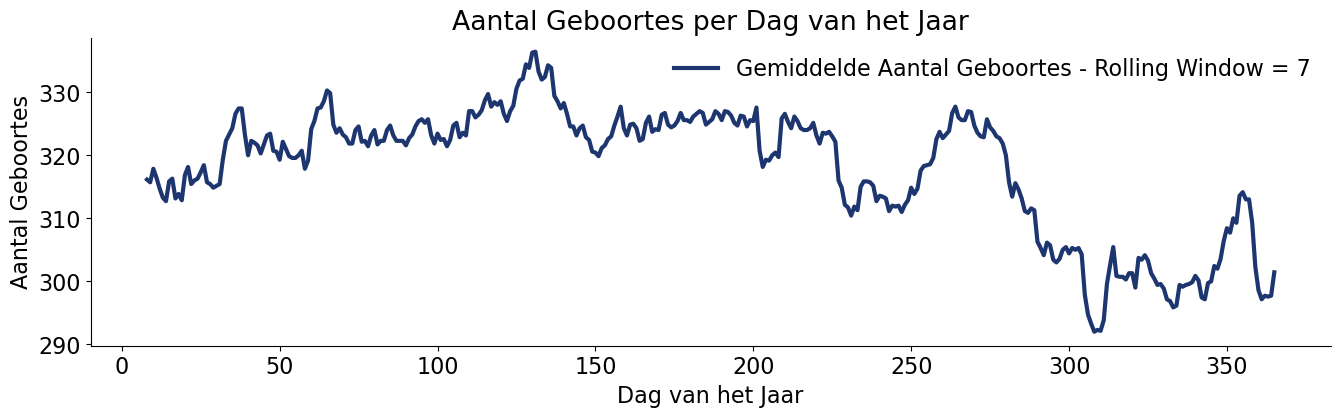

In [20]:
fig, ax = plt.subplots(figsize=(16, 4))

# rollow window size for a week
window_size = 7

# Calculate the mean number of births for each day of the week with a rolling window
gemiddelde_geboortes = (geboortes_clean.groupby('dag van het jaar')
                                .size()
                                .rolling(window_size)
                                .mean())

# Plot the results
gemiddelde_geboortes.plot(ax=ax, label=f'Gemiddelde Aantal Geboortes - Rolling Window = {window_size}')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title('Aantal Geboortes per Dag van het Jaar')
ax.set_xlabel('Dag van het Jaar')
ax.set_ylabel('Aantal Geboortes')
ax.legend()

Dat ziet er al een stuk mooier uit!  We zien ook een aantal duidelijk dips & pieken verschijnen die we eerder niet zagen. We kunnen nu ook even kijken naar het gemiddeld aantal geboortes per dag van de week! Misschien worden er wel gewoon veel minder mensen geboren op zondag dan een andere dag?

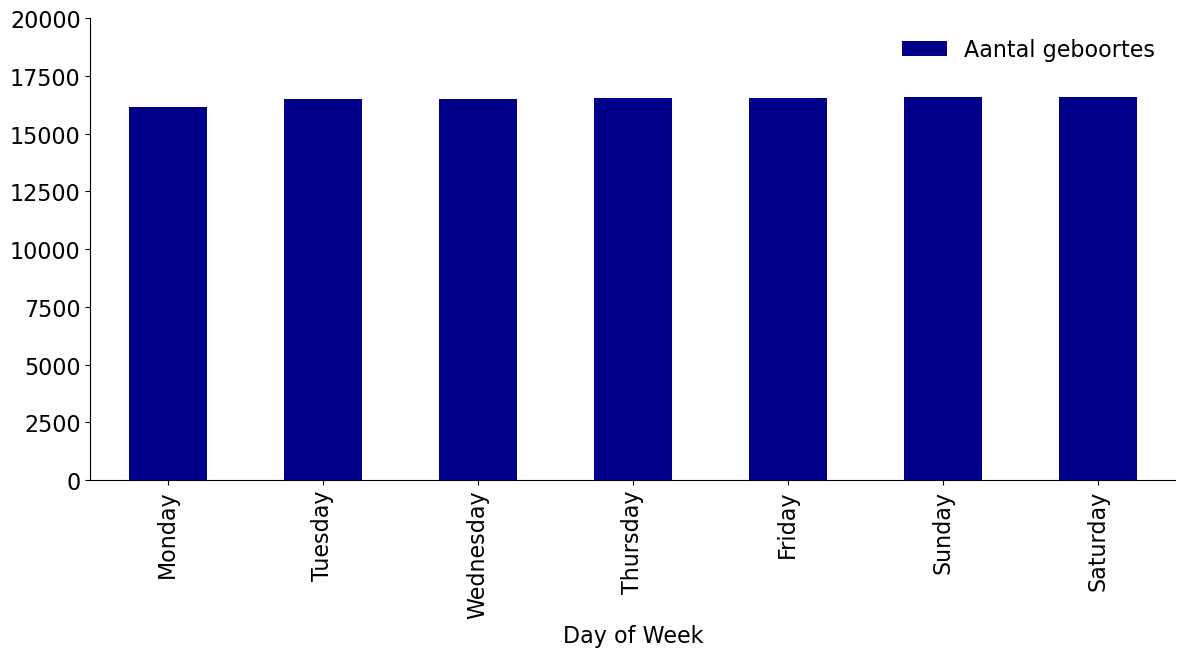

In [27]:
# Create a new column with the day of the week
if 'Day of Week' not in geboortes_clean.columns:
    geboortes_clean['Day of Week'] = geboortes_clean['geboorte datum'].dt.day_name()
    
# Group by day of the week and calculate the average number of births
avg_births_per_day = geboortes_clean.groupby('Day of Week').size().sort_values()

# Plot the data
avg_births_per_day.plot(kind='bar', color='darkblue')

# adding the legend
plt.legend(['Aantal geboortes'], bbox_to_anchor=(1, 1), 
          fancybox=True, shadow=True, facecolor='lightgrey')  # Adjust legend position if needed
plt.ylim(0, 20000)
plt.show()